# I. Import neccessary library

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# YOUR CODE HERE (OPTION) 
# If you need other libraries, you can import them here
import seaborn as sns

# II. Read file .csv

In [2]:
clean_df = pd.read_csv('../data/processed/processed_data.csv')
clean_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,stroke
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,1
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,28.1,1
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,1
3,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,1
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,1


# III. Making questions:

**Question 2:** How can we predict the probability of a person based on their personality and comorbidities? 

**Purpose of this question:** to dianose the probability of stroke of a person

Step 1: Look at the features to pick the best feature for our model.

In [3]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   int64  
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  stroke             5110 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 439.3+ KB


Step 2: Make decision to pick which model is used and import neccessary library

In [4]:
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import sklearn.preprocessing
from sklearn.tree import plot_tree

import warnings
warnings.filterwarnings("ignore")

Step 3: Feature engineering, convert numerical in `bmi` and `avg_glucose_level` into categorical by classify them in group like ['Underweight', 'Normal weight', 'Overweight', 'Obese'] and ['Normal', 'Prediabetes', 'Diabetes']

In [5]:
clean_df['age_group'] = pd.cut(clean_df['age'], bins=[-1,20,40,60,100],labels=['0-20','21-40','41-60','61-100'])
clean_df = clean_df[clean_df['gender'] != 'Other']
clean_df['gender_age_group'] = clean_df['gender'].astype(str) + '_' + clean_df['age_group'].astype(str)
clean_df = clean_df.loc[clean_df['age_group'].notna(),:]

In [6]:
bins = [0, 18.5, 25, 30, float('inf')]
labels = ['Underweight', 'Normal weight', 'Overweight', 'Obese']
clean_df['bmi_group'] = pd.cut(clean_df['bmi'], bins=bins, labels=labels)

In [7]:
bins = [0, 140, 200, float('inf')]
labels = ['Normal', 'Prediabetes', 'Diabetes']
clean_df['avg_glucose_level_group'] = pd.cut(clean_df['avg_glucose_level'], bins=bins, labels=labels)

Step 4: Show the dataframe after engineering.

In [8]:
clean_df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,stroke,age_group,gender_age_group,bmi_group,avg_glucose_level_group
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,1,61-100,Male_61-100,Obese,Diabetes
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,28.1,1,61-100,Female_61-100,Overweight,Diabetes
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,1,61-100,Male_61-100,Obese,Normal


Step 5: Feature selection, select feature that will contribute to our model and reindex columns.

In [9]:
feature_selected = clean_df.drop(columns=['id', 'age', 'gender', 'age_group', 'bmi', 'avg_glucose_level'])
feature_selected = feature_selected.reindex(columns=['hypertension', 'heart_disease',  'gender_age_group','ever_married', 'work_type', 'Residence_type','bmi_group','avg_glucose_level_group', 'stroke'])

In [10]:
feature_selected.head(3)

,hypertension,heart_disease,gender_age_group,ever_married,work_type,Residence_type,bmi_group,avg_glucose_level_group,stroke
0,0,1,Male_61-100,Yes,Private,Urban,Obese,Diabetes,1
1,0,0,Female_61-100,Yes,Self-employed,Rural,Overweight,Diabetes,1
2,0,1,Male_61-100,Yes,Private,Rural,Obese,Normal,1


Step 6: Transform the data by using label encoder.

In [11]:
label_encoder = sklearn.preprocessing.LabelEncoder()
for col in feature_selected.columns:
    feature_selected[col] = label_encoder.fit_transform(feature_selected[col])

In [12]:
feature_selected

,hypertension,heart_disease,gender_age_group,ever_married,work_type,Residence_type,bmi_group,avg_glucose_level_group,stroke
0,0,1,7,1,2,1,1,0,1
1,0,0,3,1,3,0,2,0,1
2,0,1,7,1,2,0,1,1,1
3,0,0,2,1,2,1,1,2,1
4,1,0,3,1,3,0,0,2,1
...,...,...,...,...,...,...,...,...,...
5105,1,0,3,1,2,1,2,1,0
5106,0,0,3,1,3,1,1,1,0
5107,0,0,1,1,3,0,1,1,0
5108,0,0,6,1,2,0,2,2,0


Step 7: Split data into train, test set.

In [13]:
train_sample, test_sample = feature_selected.iloc[:round(feature_selected.shape[0] * 0.8), :], feature_selected.iloc[round(feature_selected.shape[0] * 0.8):,:]

In [14]:
print(f'Train_sample: {train_sample.shape}')
print(f'Test sample: {test_sample.shape}')

Train_sample: (4087, 9)
Test sample: (1022, 9)


Step 7.1: In train set, split into train and validation set.

In [15]:
def getTrainValSample(data, fold):
    begin_pos = round(data.shape[0] * fold / 10)
    length = round(data.shape[0] * 1 / 10)

    train = pd.concat([data.iloc[0:begin_pos, :], data.iloc[begin_pos+length:, :]]).to_numpy()
    val = data.iloc[begin_pos: begin_pos+length,:].to_numpy()

    x_train, y_train = train[:, :-1], train[:, -1]
    x_val, y_val = val[:, :-1], val[:, -1]
    return (x_train, y_train), (x_val, y_val)

Step 8: Train and validate our model using K-Fold. Store the result to dataframe named `decisionModel`

In [16]:
train_errors_decision_tree = []
val_errors_decision_tree = []
for i in range(10):
    train, val = getTrainValSample(train_sample, i)
    model = DecisionTreeClassifier(criterion="entropy")
    model.fit(train[0], train[1])
    train_errors_decision_tree.append(model.score(train[0], train[1]))
    val_errors_decision_tree.append(model.score(val[0], val[1]))
    
decisionModel = pd.DataFrame({'Train Accuracy': train_errors_decision_tree,
                 'Validation Accuracy': val_errors_decision_tree
                 })

Step 9: Visualize the result using line chart

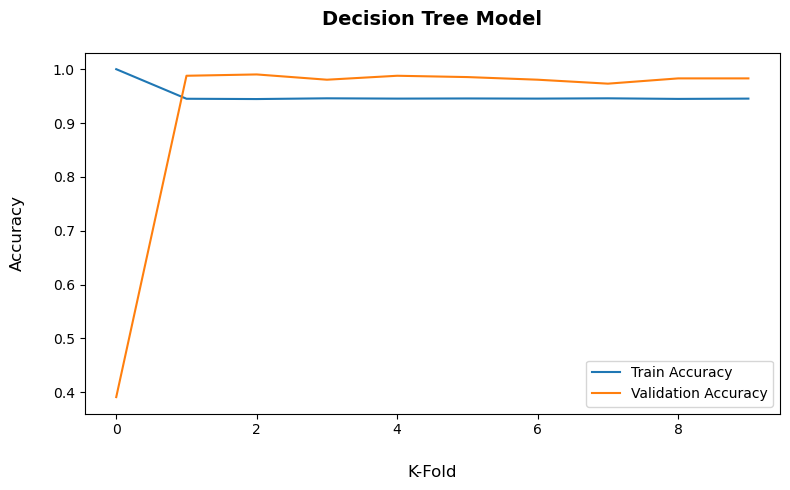

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))

decision_tree_train_line, = ax.plot(decisionModel['Train Accuracy'])
decision_tree_val_line, = ax.plot(decisionModel['Validation Accuracy'])

ax.set_title("Decision Tree Model", fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel("K-Fold", fontsize=12, labelpad=20)
ax.set_ylabel("Accuracy", fontsize=12, labelpad=20)
ax.legend([decision_tree_train_line, decision_tree_val_line], decisionModel.columns, loc="best")

plt.tight_layout()
plt.show()

**Observation:** In training phase, model get a higher score in validation.

In [18]:
x_train, y_train = train_sample.iloc[:, :-1], train_sample.iloc[:, -1:]
x_test, y_test = test_sample.iloc[:, :-1], test_sample.iloc[:, -1:]
print(f"x_train shape: {x_train.shape}\n"
      f"y_train shape: {y_train.shape}"
      )

x_train shape: (4087, 8)
y_train shape: (4087, 1)


Step 10: Conduct training the model in the whole training set.

In [19]:
model = DecisionTreeClassifier(criterion='entropy')
model.fit(x_train, y_train)
model.get_depth()

16

Step 11: Report about the result after train and test model.

In [20]:
y_train_pred = model.predict(x_train)
report = classification_report(y_true=y_train, y_pred=y_train_pred, labels=model.classes_)
print(report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3838
           1       0.98      0.18      0.31       249

    accuracy                           0.95      4087
   macro avg       0.96      0.59      0.64      4087
weighted avg       0.95      0.95      0.93      4087



Step 12: Evaluate model and show the accuracy together with the figure of tree

In [21]:
y_pred = model.predict(x_test)
accuracy_predict = accuracy_score(y_test, y_pred)
print(f"accuracy test: {accuracy_predict}")

accuracy test: 0.9843444227005871


In [22]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=0.5, square=True, cmap='Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix', size=15)
    plt.show()

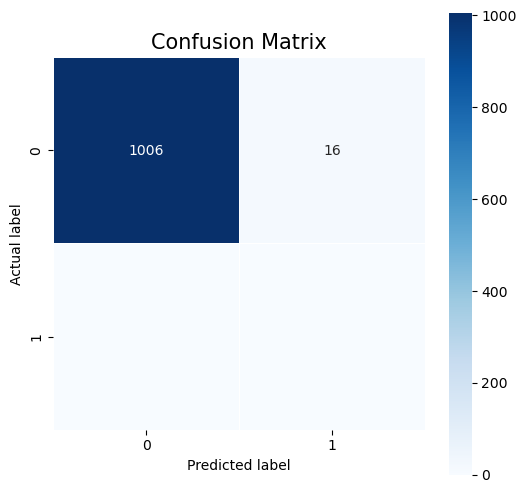

In [23]:
evaluate_model(model, x_test, y_test)

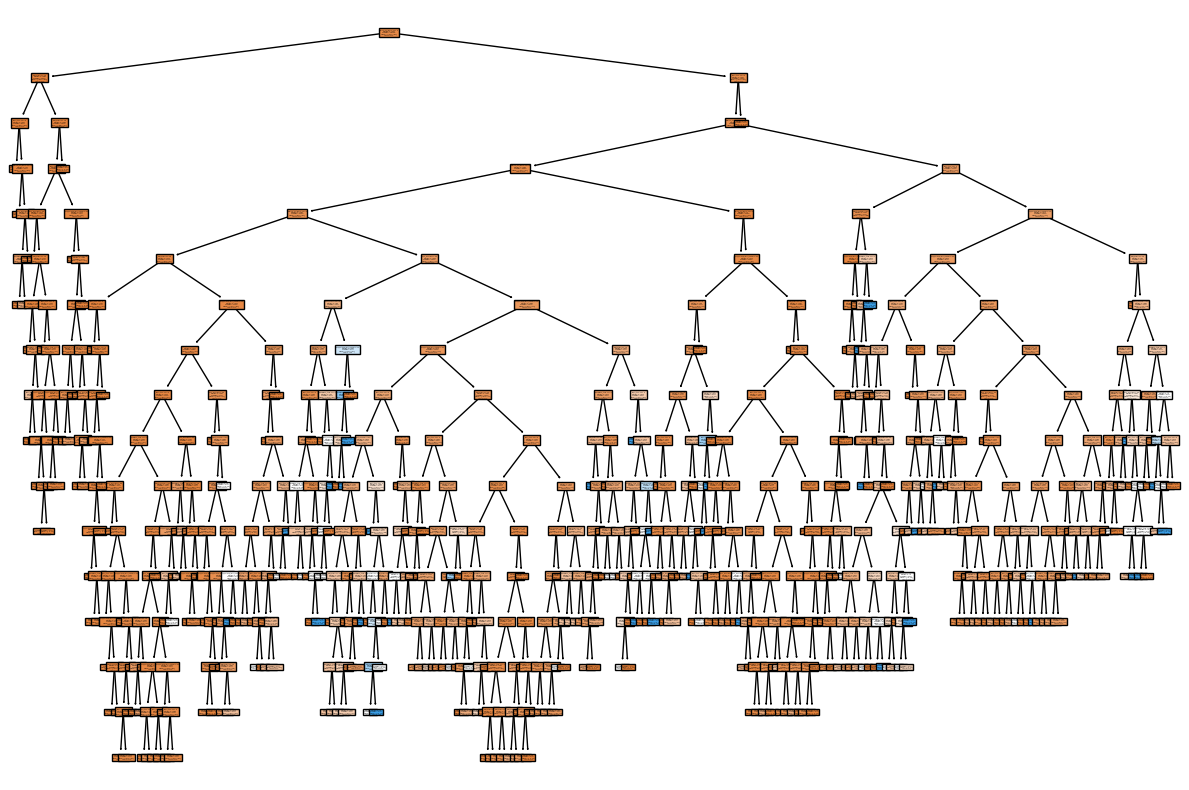

In [24]:
plt.figure(figsize=(15,10))
plot_tree(model, filled=True, feature_names=feature_selected.columns, class_names=['False', 'True'], proportion=True)
plt.savefig('tree.png')
plt.show()

Step 13: Conclude which factor affect mostly to the model.

In [25]:
importances = model.feature_importances_
feature_selected.drop(columns='stroke', inplace=True)
importances_df = pd.DataFrame({
    'Feature': feature_selected.columns,
    'Importance': importances
})
importances_df = round(importances_df.sort_values(by='Importance', ascending=False), 2)
print(importances_df)

                   Feature  Importance
2         gender_age_group        0.32
4                work_type        0.18
5           Residence_type        0.13
6                bmi_group        0.12
0             hypertension        0.07
1            heart_disease        0.07
7  avg_glucose_level_group        0.07
3             ever_married        0.04


**Conclusion:** We can apply this model to predict the probability of stroke with accuracy 0.98. And the most important feature in this is gender_age_group